# The Wilson-Cowan model

In this notebook, the basic use of the implementation of the Wilson-Cowan (`wc`) model is presented. 

In the `wc` model, the activity of a particular brain region is defined by a coupled system of excitatory (E) and inhibitory (I) neuronal populations with the mean firing rates of the E and I pools being the dynamic variables, as first described by Wilson and Cowan in 1972 ( H.R. Wilson and J.D. Cowan. *Excitatory and inhibitory interactions in localized populations of model neurons*. Biophys. J., 12:1–24 (1972)) 

In [1]:
# change to the root directory of the project
import os
if os.getcwd().split("/")[-1] == "examples":
    os.chdir('..')
# get the current directory
cwd = os.getcwd()


# Print the current working directory
print("Current working directory: {0}".format(cwd))

In [2]:
from neurolib.models.wc import WCModel
# Some useful functions are provided here
import neurolib.utils.functions as func
import neurolib.utils.stimulus as stim
import numpy as np
import scipy

In [3]:
import math

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import glob

from neurolib.models.wc import WCModel

import neurolib.utils.loadData as ld
import neurolib.utils.functions as func

# a nice color map
plt.rcParams['image.cmap'] = 'plasma'

In [15]:
wc = WCModel()
wc.params['duration'] = 2.0*1000

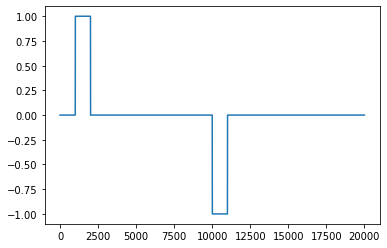

In [6]:
stimulus = np.zeros((1,20000))
stimulus[0][1000:2000] = 1
stimulus[0][10000:11000] = -1
plt.plot(stimulus.T)



In [16]:
stimulus = stim.StepInput(step_size=0.001,  start=5, end=100, n=1).to_model(wc)


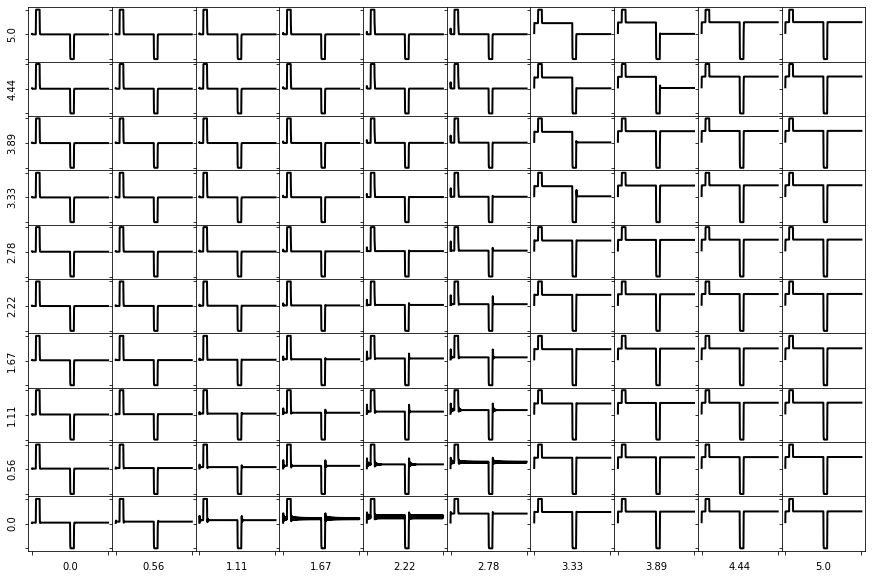

In [61]:
max_exc = []
min_exc = []
ex = []
wc = WCModel()
wc.params['duration'] = 2.0*1000
wc.params["a_exc"] = 1
wc.params["a_inh"] = 1
#wc.params["control_term_E"] = stimulus
# these are the different input values that we want to scan
exc_inputs_n = 10
inh_inputs_n = 10
exc_inputs = np.linspace(0, 5, exc_inputs_n)
inh_inputs = np.linspace(0, 5, inh_inputs_n)
fig,a =  plt.subplots(inh_inputs_n,exc_inputs_n,  sharex='col', sharey='row', figsize=(15,10))
for i, inh_ext in enumerate(inh_inputs):
    for j, exc_ext in enumerate(exc_inputs):
        # Note: this has to be a vector since it is input for all nodes
        # (but we have only one node in this example)
        wc.params['exc_ext'] = exc_ext
        wc.params['inh_ext'] = inh_ext
        wc.params["control_term_E"] = stimulus
        #wc.params["control_term_I"] = stimulus
        wc.run()
        # we add the maximum and the minimum of the last second of the 
        # simulation to a list
        max_exc.append(np.max(wc.exc[0, -int(1000/wc.params['dt']):]))
        min_exc.append(np.min(wc.exc[0, -int(1000/wc.params['dt']):]))
        #print(np.shape(wc.exc))
        ex = wc.exc


        #plt.figure(figsize = (20, 6))
        #plt.plot(range(int(wc.params['duration']/wc.params['dt'])), ex[0].tolist(), c='k', lw = 2)
        #plt.show()
        
        
        #fig, ax = plt.subplots(50, 50, sharex='col', sharey='row')

        #ax[i, j].plot(range(int(wc.params['duration']/wc.params['dt'])), ex[0].tolist(), c='k', lw = 2)
        
        
        
        a[inh_inputs_n-i-1][j].plot(range(int(wc.params['duration']/wc.params['dt'])), ex[0].tolist(), c='k', lw = 2)
        #a[9-i][j].plot(s)

        # Turn off tick labels
        a[inh_inputs_n-i-1][j].set_yticklabels([])
        a[inh_inputs_n-i-1][j].set_xticklabels([])
        
        if(i==0):
            a[inh_inputs_n-i-1][j].set_xlabel(round(exc_ext, 2))
        if(j==0):
            a[inh_inputs_n-i-1][j].set_ylabel(round(inh_ext, 2))
       

        #plt.show()

        #ex = wc.inh
        #plt.plot(range(int(wc.params['duration']/wc.params['dt'])), ex[0].tolist(), c='k', lw = 2)
        #plt.show()

        #print(np.shape(wc.bracets))
        #plt.plot(wc.params['duration']/wc.params['dt'], wc.exc[0], c='k', lw = 2)
        #plt.show()

plt.subplots_adjust(hspace=.0)
plt.subplots_adjust(wspace=.0)
#fig.tight_layout()
plt.show()

In [ ]:
def optimal_control(wс, exc_exp, inh_exp, debug = False):
    
    #h = (xn-x0)/n_step
    #times = np.arange(0, xn+h, h)
    times = range(int(wc.params['duration']/wc.params['dt']))
    #print(times)
    u_i = stim.StepInput(step_size=0,  start=0.1, end=0.2, n=1).to_model(wc)
    #print("u_i", u_i)
    u_e = stim.StepInput(step_size=0,  start=0.1, end=0.2, n=1).to_model(wc)
    #u_i = stimulus
    #u_e = stimulus
    print("u_e", u_e)
    for l in range(20):

        wc.params["control_term_E"] = u_e
        wc.params["control_term_I"] = u_i

        
        wc.run()
        #print("check", wc.brackets_E)
        ex = wc.exc
        inh = wc.inh
        
        if(debug):
            print(np.shape(ex))
            print(int(wc.params['duration']/wc.params['dt']))
        if (l%1==0):
            plt.figure(figsize = (20, 6))
            plt.plot(wc.t, exc_exp.T,c = 'blue',label="exc_target")
            plt.plot(wc.t, ex[0].tolist(), c='k', lw = 2, label="exc")
            plt.plot(wc.t, u_e.T, c='r', lw = 2,label="stimulus")
            plt.legend()
            plt.show()
        
        
        lambdas = euler_backwards(wc, exc_exp, inh_exp, wc.params['dt'], int(math.ceil(wc.params['duration']/wc.params['dt'])), debug)
        if debug:
            print("lambdas", lambdas)
            plt.figure(figsize = (20, 6))
            plt.plot(wc.t, [x[0] for x in lambdas], c='blue', lw = 2, label="lambdas")
            plt.legend()
            plt.show()
        
        w = [0,0]
        
        grad = grad_f(w, u_e,u_i, lambdas, times)
        if debug:
            print("grad", grad)

            plt.figure(figsize = (20, 6))
            plt.plot(wc.t, np.array(grad[0]), c='red', lw = 2, label="grad")
            plt.legend()
            plt.show()
        
        step_size_adj = 10 #0.005
        
        
        step_size_adj = bisection(wc, step_size_adj,u_e,u_i,grad, times, exc_exp, debug)
        #if(l == 0):
        #    step_size_adj = 0.1
            
        if debug:
            print("step", step_size_adj)
            print("step_new", step_size_adj*np.array(grad[0]))

        u_e = u_e-step_size_adj*np.array(grad[0])
        u_i = u_i-step_size_adj*np.array(grad[1])

            
            

In [7]:
def bisection(model, step_size, u_e, u_i, grad, times, exc_exp, debug = False):
    cost_temp = 10**12
    while step_size > 0.000001:
        u_e_1 = u_e-step_size*np.array(grad[0])
        u_i_1 = u_i-step_size*np.array(grad[1])

        model.params["control_term_E"] = u_e_1
        model.params["control_term_I"] = u_i_1


        wc.run()
        ex = model.exc
        inh = model.inh
        
        if debug:
            plt.figure(figsize = (8, 5))
            plt.plot(model.t, exc_exp.T,c = 'blue', label="exc_target")
            plt.plot(model.t, ex[0].tolist(), c='k', lw = 2, label="exc")
            plt.plot(model.t, u_e_1.T, c='r', lw = 2, label="stimulus")
            plt.legend()
            plt.show()

        cost = cost_f(ex[0], exc_exp, u_e_1, u_i_1, times)
        if debug:
            print("cost", cost)
            print("step_size", step_size)
        #step_size = step_size/2
        #cost_temp = cost
        if(cost<cost_temp):
            step_size = step_size/2
            cost_temp = cost
        else:
            return step_size
        
    return 0
        

def cost_f(x, x_, u_exc, u_inh, times):

    #return np.sum(1/2*(x_-x)**2) 
    return scipy.integrate.simps(1/2*(x_-x)**2,times) \
            #+ 0.3 * ((np.sqrt(scipy.integrate.simps(u_exc**2, times))) \
            # + np.sqrt(scipy.integrate.simps(u_inh**2, times)))
    #return  0.3 * (np.sqrt(scipy.integrate.simps(u_exc**2, times)) \
    #        + np.sqrt(scipy.integrate.simps(u_inh**2, times)) \
    #        + 0.5 * scipy.integrate.simps(u_exc**2 + u_inh**2, times)) \
    #        + scipy.integrate.simps((x-x_)**2,times)

In [27]:
def S_E(x, model):
    a_exc = model.params["a_exc"]
    mu_exc = model.params["mu_exc"]
    return 1.0 / (1.0 + np.exp(-a_exc * (x - mu_exc)))
    #return 1.0/(np.exp(-a_exc*(x-mu_exc))+1.0)
    

def S_I(x, model):
    a_inh = model.params["a_inh"]
    mu_inh = model.params["mu_inh"]
    #return 1.0/(np.exp(-a_inh*(x-mu_inh))+1.0)
    return 1.0 / (1.0 + np.exp(-a_inh * (x - mu_inh)))

def dh1_dE(model, i):
    a_exc = model.params["a_exc"]
    C_EE = model.params["c_excexc"]
    mu_exc = model.params["mu_exc"]
    brackets_E = model.brackets_E[0][i]
    E_j = model.exc[0][i]

    return -1-S_E(brackets_E, model)+(a_exc*np.exp(-a_exc * ( brackets_E - mu_exc)))*(S_E(brackets_E, model)**2)*C_EE*(1-E_j)
    #return -1-S_E(brackets_E, model)+(a_exc*np.exp(-a_exc*(brackets_E - mu_exc))/(1 + np.exp(-a_exc*(brackets_E - mu_exc)))**2)*C_EE*(1-E_j)
    #return -1

def dh2_dI(model, i):
    a_inh = model.params["a_inh"]
    mu_inh = model.params["mu_inh"]
    C_II = model.params["c_inhinh"]
    brackets_I = model.brackets_I[0][i]
    I_j = model.inh[0][i]
    #return -1-S_I(brackets_I, model)+(a_inh * np.exp(-a_inh *(brackets_I - mu_inh))/(1 + np.exp(-a_inh *(brackets_I - mu_inh)))**2)*(-C_II)*(1-I_j)
    return -1-S_I(brackets_I, model)+(a_inh*np.exp(-a_inh * (brackets_I - mu_inh)))*(S_I(brackets_I, model)**2)*(-C_II)*(1-I_j)
    #return -1
def dh1_dI(model, i):
    a_exc = model.params["a_exc"]
    C_IE = model.params["c_inhexc"]
    mu_exc = model.params["mu_exc"]
    brackets_E = model.brackets_E[0][i]
    E_j = model.exc[0][i]
    #return 0 
    #return (1-E_j)*(a_exc*np.exp(-a_exc*(brackets_E - mu_exc))/(1 + np.exp(-a_exc*(brackets_E - mu_exc)))**2)*(-C_IE)
    return (1-E_j)*(a_exc*np.exp(-a_exc * (brackets_E - mu_exc)))*(S_E(brackets_E, model)**2)*(-C_IE)

def dh2_dE(model, i):
    a_inh = model.params["a_inh"]
    mu_inh = model.params["mu_inh"]
    C_EI = model.params["c_excinh"]
    brackets_I = model.brackets_I[0][i]
    I_j = model.inh[0][i]
    #return 0 
    return (1-I_j)*(a_inh*np.exp(-a_inh * (brackets_I - mu_inh)))*(S_I(brackets_I, model)**2)*C_EI
    #return (1-I_j)*(a_inh*np.exp(-a_inh*(brackets_I - mu_inh))/(1 + np.exp(-a_inh*(brackets_I - mu_inh)))**2)*C_EI

    
def lambda_der(model, lambdas, ex_exp, inh_exp, i, debug = False):
    
    tauE = model.params["tau_exc"]
    tauI = model.params["tau_inh"]
    
    Dx_doth = np.array([[ -1*tauE, 0], 
                  [0, -1*tauI]])
    
    Dxf = np.array([model.exc[0][i]-ex_exp[i], model.inh[0][i]-inh_exp[i]])
    
    Dxh = np.array([[ dh1_dE(model,i), dh1_dI(model, i)], 
                  [dh2_dE(model, i), dh2_dI(model, i)]])
    if debug:
        print("a", model.exc[0][i])
        print("b", ex_exp[i])
        print("Dxh", Dxh)
        print("Dxf", Dxf)
        print("lambdas[i]@Dxh",lambdas[i]@Dxh)
        print("Dxf + lambdas[i]@Dxh", Dxf + lambdas[i]@Dxh)
        print((Dxf + lambdas[i]@Dxh)@np.linalg.inv(Dx_doth))
        print("__________________________________")
    
    return (Dxf + lambdas[i]@Dxh)@np.linalg.inv(Dx_doth)

def euler_backwards(model, ex_exp, inh_exp, step, n, debug = False):
     
    lambdas = [[0,0] for i in range(n)]
    
    #inh = wc.inh[0]
    #ex = wc.exc[0]
    if debug:
        print("exc", model.exc[0])
        print("exc_exp", ex_exp)
    
    for i in range(n-2,-1,-1):
        lambdas[i] = lambdas[i+1]-step*lambda_der(model, lambdas, ex_exp, inh_exp, i, debug) #i+1 or i
        #print("lambdas", lambdas[i])

    return lambdas

def grad_f(w, u_e, u_i, lambdas, times): ##TODO add cost components
    lambda_list = [[x[0] for x in lambdas],[x[1] for x in lambdas]]
    f_list = [np.abs(w[0]*u_e[0]).tolist(), np.abs(w[1]*u_i[0]).tolist()]
    summed = [[x + y for (x, y) in zip(f_list[0], lambda_list[0])],[x + y for (x, y) in zip(f_list[1], lambda_list[1])]]
    return summed
    #return summed
    #return [[x[0] for x in lambdas],[x[1] for x in lambdas]] + [0.3*np.abs(u_e).tolist(), 0.3*np.abs(u_i).tolist()] 
            #+ [(1/np.sqrt(scipy.integrate.simps(u_e**2, times)))*u_e, (1/np.sqrt(scipy.integrate.simps(u_i**2, times)))*u_i]
    

# Toy example

In [43]:
from neurolib.models.wc import WCModel
wc = WCModel()
wc.params["a_exc"] = 1
wc.params["a_inh"] = 1
#wc.params["c_inhinh"] = 0
#wc.params["c_excinh"] = 0
#wc.params["c_inhexc"] = 0
#wc.params["c_excexc"] = 0
#wc.params["tau_exc"] = 1  
#wc.params["tau_inh"] = 1
#wc.params["exc_ext"] = 0
#wc.params["inh_ext"] = 0
#wc.params["K_gl"] = 0
#wc.params["dt"] = 0.1
wc.params['duration'] = 10


u_e [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0.]]


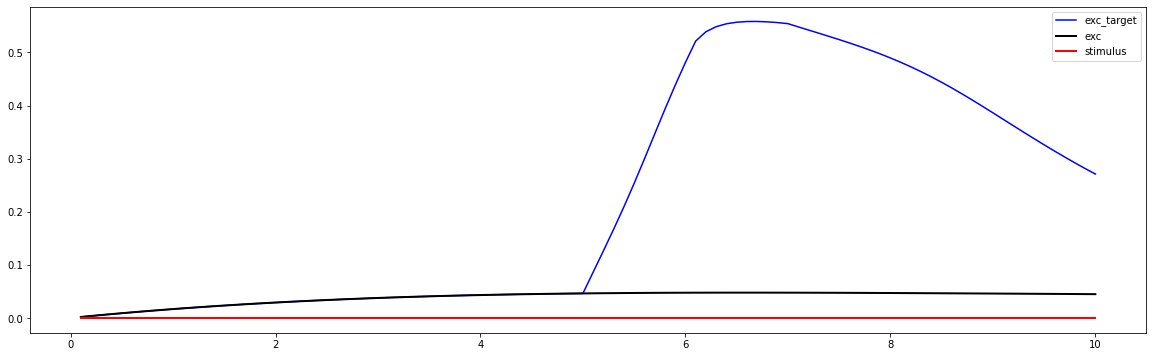

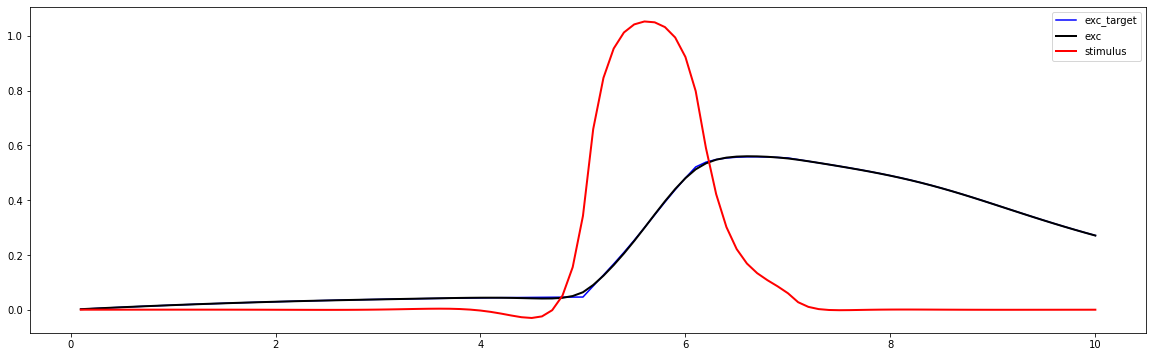

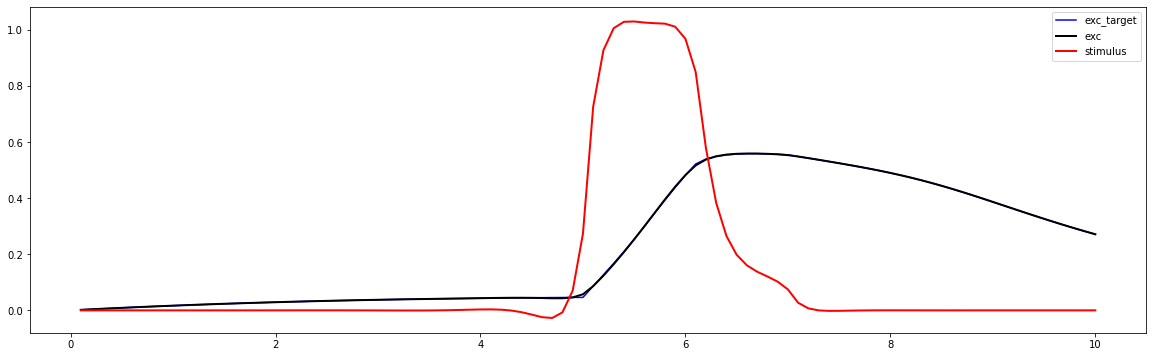

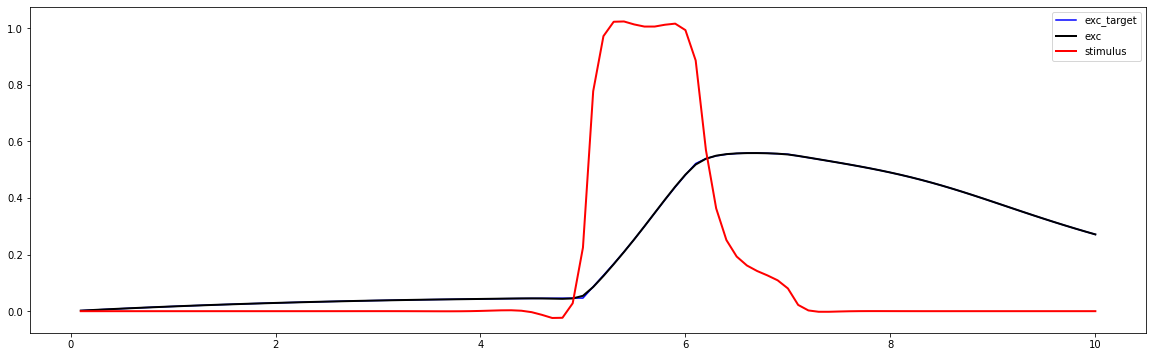

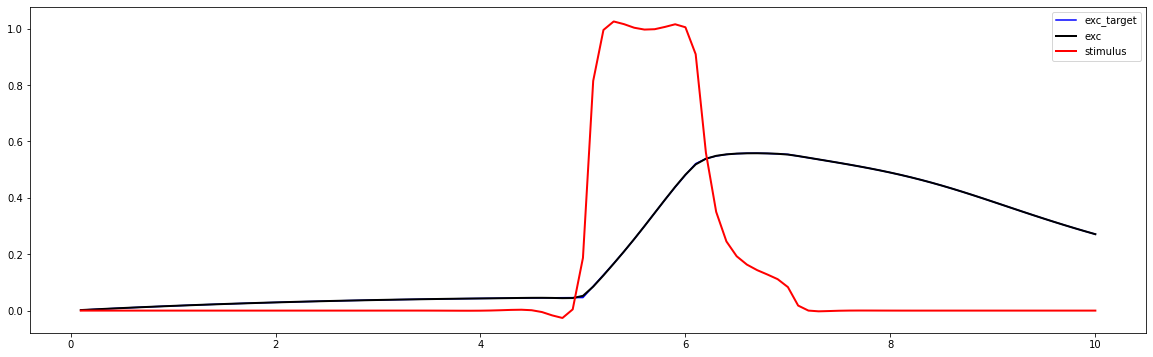

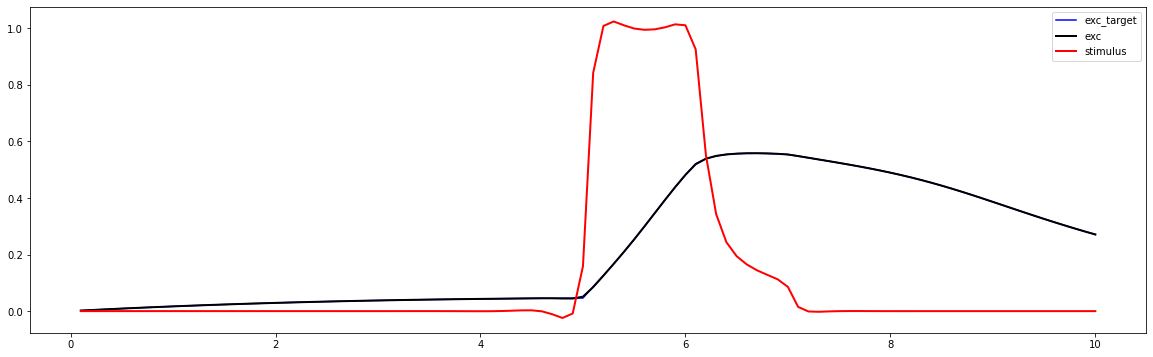

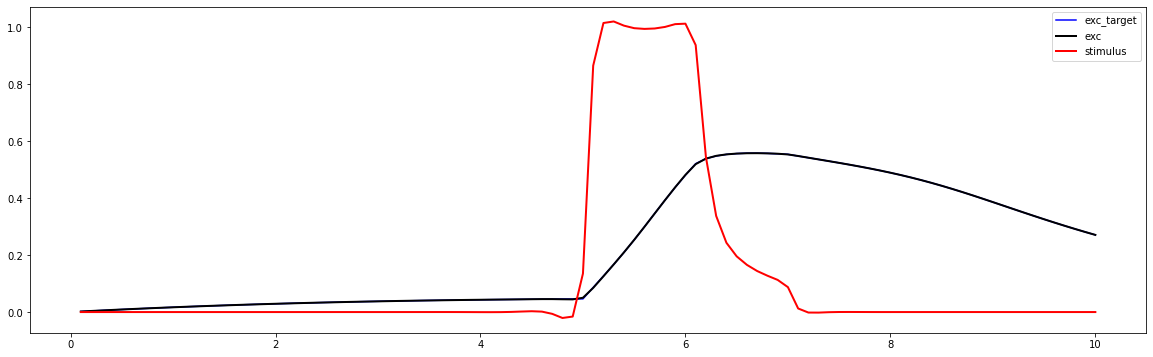

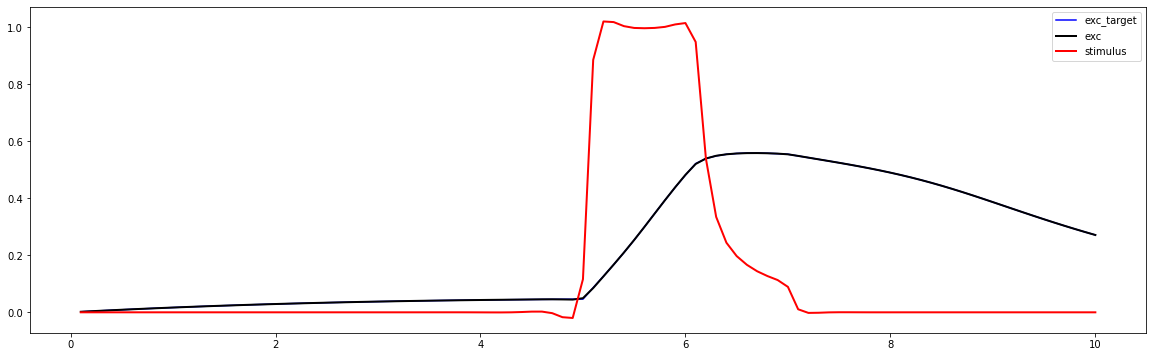

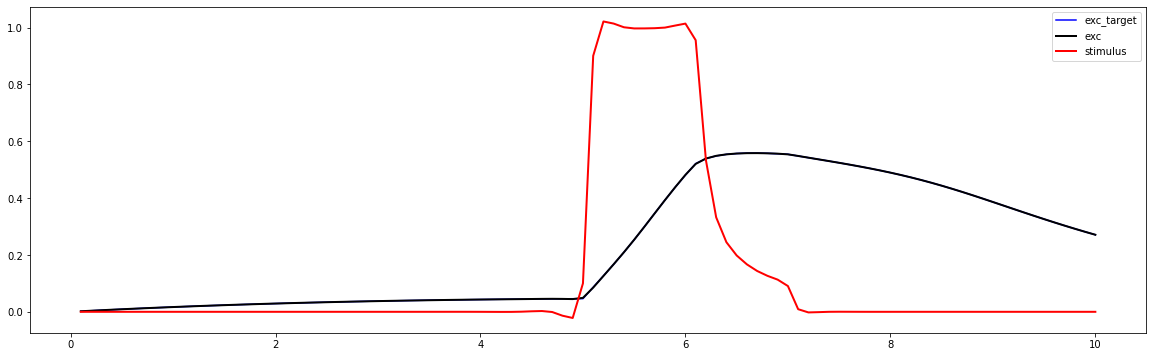

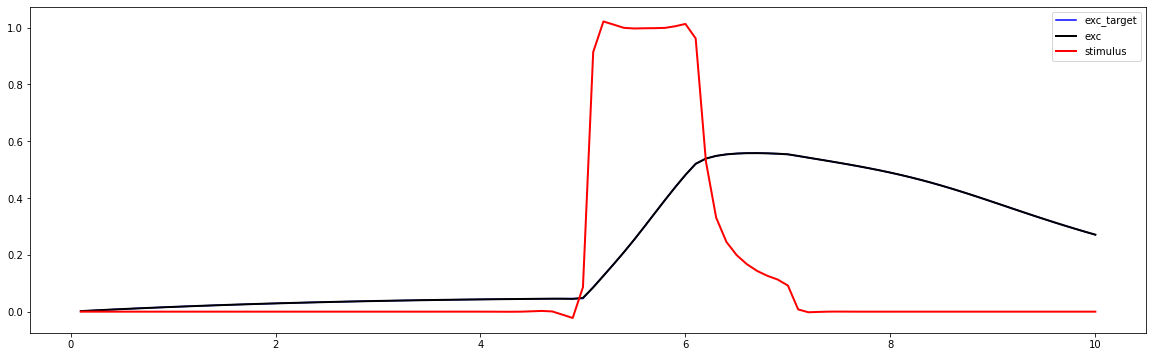

In [45]:
#wc = WCModel()
#wc.params["control_term"] = s
#wc.params['exc_ext'] = 3.5
#wc.params['inh_ext'] = 3.5
exc=wc.exc[0]
inh = wc.inh[0]

optimal_control(wc, exc,inh, debug = False)
#optimal_control(wc, stimulus, target, target)

# Better example

In [67]:
from neurolib.models.wc import WCModel
wc = WCModel()
wc.params["a_exc"] = 1
wc.params["a_inh"] = 1

wc.params['exc_ext'] = 3.33
wc.params['inh_ext'] = 3.89


#wc.params["c_inhinh"] = 0
#wc.params["c_excinh"] = 0
#wc.params["c_inhexc"] = 0
#wc.params["c_excexc"] = 0
#wc.params["tau_exc"] = 1  
#wc.params["tau_inh"] = 1
#wc.params["exc_ext"] = 0
#wc.params["inh_ext"] = 0
#wc.params["K_gl"] = 0
#wc.params["dt"] = 0.1
wc.params['duration'] = 2000


1
wc.exc[0] [0.05190119 0.07171252 0.09140039 ... 0.35820838 0.35820838 0.35820838]


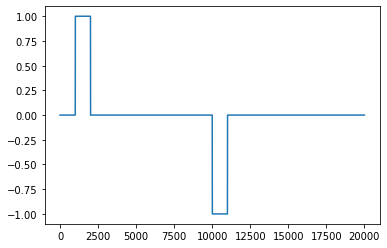

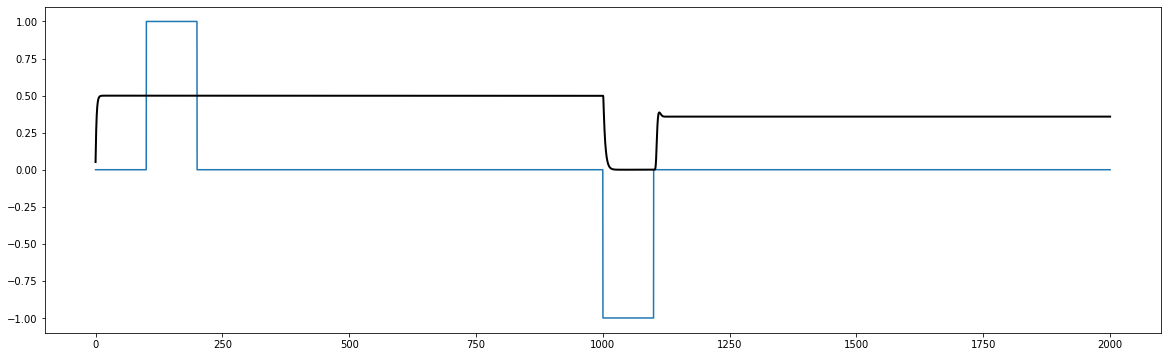

In [77]:
#stimulus
stimulus = np.zeros((1,20000))
stimulus[0][1000:2000] = 1
stimulus[0][10000:11000] = -1
plt.plot(stimulus.T)



wc.params["control_term_E"] = stimulus
#wc.params["control_term_I"] = stimulus
wc.run()

plt.figure(figsize = (20, 6))
plt.plot(wc.t, stimulus.T)
plt.plot(wc.t, wc.inh[0].tolist(), c='k', lw = 2)
print(wc.params["a_exc"])
print("wc.exc[0]",wc.inh[-1])
#0.02788229


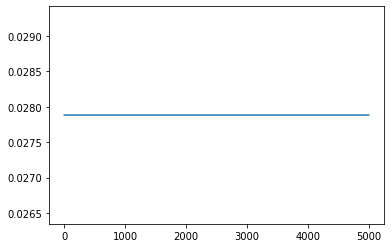

In [82]:
target_low = np.zeros(5000)
target_low[:] = 0.02788229
plt.plot(target_low)

target_low_inh = np.zeros(5000)
target_low_inh[:] = 0.35820838

u_e [[0. 0. 0. ... 0. 0. 0.]]


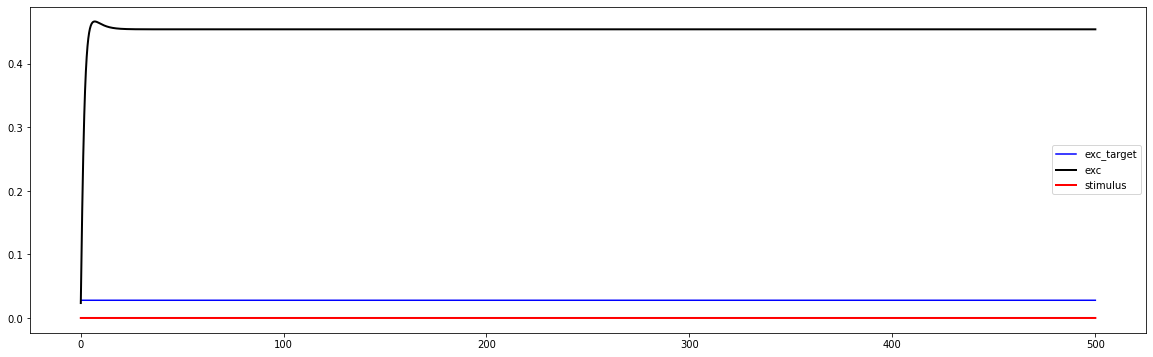

KeyboardInterrupt: 

In [84]:
wc = WCModel()
wc.params["a_exc"] = 1
wc.params["a_inh"] = 1

wc.params['exc_ext'] = 3.33
wc.params['inh_ext'] = 3.89

wc.params['duration'] = 500


optimal_control(wc, target_low,target_low_inh, debug = False)

#optimal_control(wc, stimulus, target, target)

In [34]:
wc.params["control_term"] = stimulus

In [ ]:
#target signal


wc = WCModel()
#wc.params["control_term"] = s
wc.params['exc_ext'] = 0
wc.params['inh_ext'] = 0
wc.run()
plt.plot(range(int(wc.params['duration']/wc.params['dt'])), wc.exc[0].tolist(), c='k', lw = 2)
plt.plot(wc.params["control_term_E"].T)
plt.show()
target_exc = wc.exc


#target = stim.SinusoidalInput(amplitude=0.5, frequency=1).to_model(wc)
#plt.plot(target.T)

#exc_5000 0.013072727462704856
#exc_19999 0.4931700303710192
#inh_5000 0.2985821792704872
#inh_19999 0.49998300736421963


#target
target_exc = np.zeros(20000)
target_exc[1000:19999] = 0.013072727462704856


target_inh = np.zeros(20000)
target_inh[1000:19999] = 0.2985821792704872

## Drafts

In [131]:
wc.params['exc_ext'] = 0
wc.params['inh_ext'] = 0
wc.run()

(1, 20000)


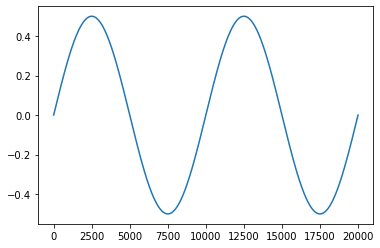

In [156]:
stimulus = stim.SinusoidalInput(amplitude=0.5, frequency=1).to_model(wc)
print(stimulus.shape)
plt.plot(stimulus.T)
wc.params["control_term"] = stimulus

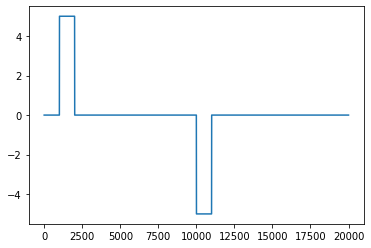

In [196]:
stimulus = np.zeros((20000))
stimulus[1000:2000] = 5
stimulus[10000:11000] = -5
plt.plot(stimulus)

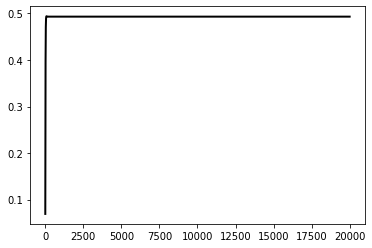

In [182]:
wc = WCModel()
#wc.params["control_term"] = s
wc.params['exc_ext'] = 3.5
wc.params['inh_ext'] = 3.5
wc.run()
plt.plot(range(int(wc.params['duration']/wc.params['dt'])), wc.exc[0].tolist(), c='k', lw = 2)
#plt.plot(s)
plt.show()
target = wc.exc[0]


In [ ]:
plt.plot(exc_inputs, max_exc, c='k', lw = 2)
plt.plot(exc_inputs, min_exc, c='k', lw = 2)
plt.title("Bifurcation diagram of the Wilson-Cowan model")
plt.xlabel("Input to exc")
plt.ylabel("Min / max exc")

In [ ]:
def dh1_dE():
    return 1

def dh2_dE():
    return 2

def dh1_dI():
    return 3

def dh2_dI():
    return 4

def df_dE():
    return 0

def df_dI():
    return 0

lambd1 = 1
lambd2 = 2
Dxh = np.array([[ dh1_dE(), dh1_dI()], 
                  [dh2_dE(), dh2_dI()]])
lambdas = np.array([lambd1, lambd2])

Dxf = np.array([df_dE(), df_dI()])

tauE = 2
tauI = 8

Dx_doth = np.array([[ -tauE, 0], 
                  [0, -tauI]])
x = np.linalg.solve(Dx_doth, b)

(Dxf - lambdas@Dxh)@np.linalg.inv(Dx_doth)



In [ ]:
exp = stim.SinusoidalInput(amplitude=0.5, frequency=0.5).to_model(wc)
#exp = stim.StepInput(step_size=0.5, start=10, end=80, n=2).to_model(wc)
plt.plot(exp.T)

## Single node simulation

In [ ]:
wc = WCModel()
wc.params['duration'] = 1.0*1000
wc.params['sigma_ou'] = 0.01

wc.run()

In [ ]:
plt.plot(wc.t, wc.exc.T, c='k', lw = 2)
plt.xlabel("t [ms]")
plt.ylabel("Activity")

## Brain network

In [ ]:
from neurolib.utils.loadData import Dataset

ds = Dataset("hcp")

In [ ]:
wc = WCModel(Cmat = ds.Cmat, Dmat = ds.Dmat)

In [ ]:
wc.params['exc_ext'] = 0.65

wc.params['signalV'] = 0
wc.params['duration'] = 20 * 1000 
wc.params['sigma_ou'] = 0.14
wc.params['K_gl'] = 3.15


wc.run(chunkwise=True)

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 3))
axs[0].imshow(func.fc(wc.exc[:, -10000:]))
axs[1].plot(wc.t, wc.exc[::5, :].T, alpha=0.8);
axs[1].set_xlim(0, 200)

In [ ]:
scores = [func.matrix_correlation(func.fc(wc.exc[:, -int(5000/wc.params['dt']):]), fcemp) for fcemp in ds.FCs]
print("Correlation per subject:", [f"{s:.2}" for s in scores])
print("Mean FC/FC correlation: {:.2f}".format(np.mean(scores)))

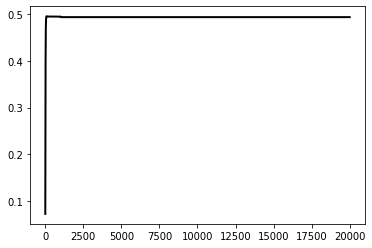

In [18]:
plt.plot(range(int(wc.params['duration']/wc.params['dt'])), ex[0].tolist(), c='k', lw = 2)